In [1]:
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import keras
import keras.layers as layers

2022-07-10 21:19:06.682450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-07-10 21:19:06.682733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We want a model that can receive an image and a selection mask and that can return the segmentation of the selected fiber

image: shape=(256, 256, 1), dtype=float32, max=0.615686297416687, min=0.0
segmentation: shape=(256, 256, 1), dtype=uint8, max=139, min=0


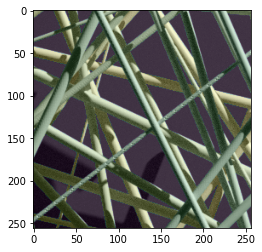

In [2]:
def load_task(dataset_path, task_id):
    # Load an image
    im = Image.open(os.path.join(dataset_path, task_id + '.png'))
    im = np.array(ImageOps.grayscale(im))
    im = im.reshape(im.shape+(1,)).astype(np.float32)/255 # one channel image
    # Load segmentation
    seg:np.ndarray = np.load(os.path.join(dataset_path, task_id+ '_seg.npz'))['y']
    return im, seg

dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
task_id = 'train0000'
im, seg = load_task(dataset_path, task_id)

print(f'image: shape={im.shape}, dtype={im.dtype}, max={np.max(im)}, min={np.min(im)}')
print(f'segmentation: shape={seg.shape}, dtype={seg.dtype}, max={np.max(seg)}, min={np.min(seg)}')
plt.imshow(im, cmap='gray')
plt.imshow(seg, alpha=0.2)

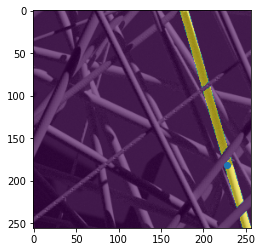

In [3]:
def select_point_and_fiber(seg):
    # Select a random point that is not background, return the mask for the fiber that the point touches.
    mask_all = seg > 0
    possible_points = np.argwhere(mask_all)
    point_index = np.random.randint(0, possible_points.shape[0]-1)
    point = possible_points[point_index]
    fiber_id = seg[point[0], point[1], point[2]]
    mask = seg == fiber_id
    selected_seg = np.zeros_like(seg, dtype=np.float32)
    selected_seg[mask] = 1.0
    return point[0:2], selected_seg

point, selected_seg = select_point_and_fiber(seg)

plt.imshow(im, cmap='gray')
plt.imshow(selected_seg, alpha=0.6)
plt.scatter(point[1], point[0])
plt.show()

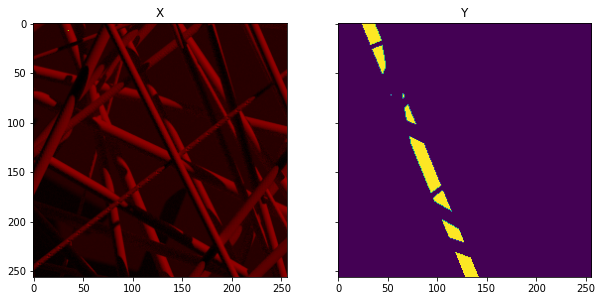

image: shape=(256, 256, 2), dtype=float32, max=1.0, min=0.0
image: shape=(256, 256, 1), dtype=float32, max=1.0, min=0.0


In [4]:
# How to create examples for training the nn
def get_example(dataset_path, task_id):
    """Creates an example for training"""
    im, seg = load_task(dataset_path, task_id)
    point, selected_seg = select_point_and_fiber(seg)
    point_channel = np.zeros_like(im, dtype=np.float32)
    point_channel[point[0], point[1], 0] = 1.0
    x = np.concatenate([im, point_channel], axis=-1)
    y = selected_seg
    return x, y

x, y = get_example(dataset_path, task_id)
preview = np.concatenate([x, np.zeros_like(x[:,:,0:1])], axis=-1) # add one channel to see it as an rgb in plt only
fig, (axX, axY) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axX.imshow(preview)
axX.set_title('X')
axY.imshow(y)
axY.set_title('Y')
plt.show()
print(f'image: shape={x.shape}, dtype={x.dtype}, max={np.max(x)}, min={np.min(x)}')
print(f'image: shape={y.shape}, dtype={y.dtype}, max={np.max(y)}, min={np.min(y)}')

In [5]:
# generators for model training input
def example_generator(dataset_path, task_list):
    for task_id in task_list:
        yield get_example(dataset_path, task_id)

def batcher(generator, batch_size):
    batch = [], []
    counter = 0
    for x, y in generator:
        batch[0].append(x)
        batch[1].append(y)
        counter += 1
        if counter % batch_size == 0:
            yield batch
            batch = [],[]
    if len(batch[0]) > 0:
        yield batch

def train_batch_gen():
    dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
    train_tasks = [f"train{i:04d}" for i in range(256)]
    for x, y in batcher(example_generator(dataset_path, train_tasks), batch_size):
        yield x, y

def val_batch_gen():
    dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
    val_tasks = [f"val{i:04d}" for i in range(64)]
    for x, y in batcher(example_generator(dataset_path, val_tasks), batch_size):
        yield x, y

batch_size = 8

train_dataset:tf.data.Dataset = tf.data.Dataset.from_generator(
    train_batch_gen, output_signature=(
        tf.TensorSpec(shape=[batch_size,256,256,2], dtype=tf.float32),
        tf.TensorSpec(shape=[batch_size,256,256,1], dtype=tf.float32))
).prefetch(2)

val_dataset = tf.data.Dataset.from_generator(
    val_batch_gen, output_signature=(
        tf.TensorSpec(shape=[batch_size,256,256,2], dtype=tf.float32),
        tf.TensorSpec(shape=[batch_size,256,256,1], dtype=tf.float32))
).prefetch(2)

# for i in tqdm(train_dataset.as_numpy_iterator()):
#     pass

2022-07-10 21:19:11.536780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:19:11.537135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-07-10 21:19:11.537244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-07-10 21:19:11.537441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_

In [6]:
def get_unet(input_size, num_classes=1):
    initial_features = 16
    inputs = layers.Input(input_size)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(inputs)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool4)
    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2D(initial_features*2**3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.concat([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge6)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv6)

    up7 = layers.Conv2D(initial_features*2**2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.concat([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge7)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv7)

    up8 = layers.Conv2D(initial_features*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.concat([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge8)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv8)

    up9 = layers.Conv2D(initial_features, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.concat([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge9)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv10 = layers.Conv2D(num_classes, 1, activation = 'sigmoid', padding='same')(conv9)

    model = keras.Model(inputs, conv10)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [7]:
unet = get_unet(input_size=[256,256,2], num_classes=1)


In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
iou_metric = keras.metrics.MeanIoU(num_classes=2)
unet.compile(optimizer=adam, loss='binary_crossentropy', metrics=[iou_metric])

In [9]:
unet.fit(train_dataset, validation_data=val_dataset)

32/32 [==============================] - 95s 3s/step - loss: 0.6160 - mean_io_u: 0.4694 - val_loss: 0.3140 - val_mean_io_u: 0.4660


In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]